<a href="https://colab.research.google.com/github/arunoda/fastai-v4/blob/master/06_3_multi_cat_cats_dogs_revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cats and Dog model with Mult Cat**

With this, we can try to see whether it could discard any non dog or cat images.

## Setting Up on Colab

You only need to run this on Colab.

In [1]:
!pip install fastai2
!git clone https://github.com/arunoda/fastai-v4
%cd fastai-v4
!pwd

     |████████████████████████████████| 194kB 2.6MB/s 
Cloning into 'fastai-v4'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 120 (delta 46), reused 49 (delta 12), pack-reused 22
Receiving objects: 100% (120/120), 129.50 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/fastai-v4
/content/fastai-v4


In [0]:
from fastai2.vision.all import *

## Load the Dataset

Loading the pets dataset

In [3]:
dataset = untar_data(URLs.PETS)

In [4]:
image_files = (dataset/"images").ls()
image_files

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_105.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_43.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_130.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_169.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_100.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_112.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_187.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_51.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_173.jpg')...]

In [5]:
dataset.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
def get_category(p):
  if p.name[0].isupper():
    return ['cat']
  else:
    return ['dog']

db = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_items = get_image_files,
    get_y = get_category,
    item_tfms = Resize(224),
    splitter = RandomSplitter(0.3)
)

In [0]:
dls = db.dataloaders(dataset/"images")

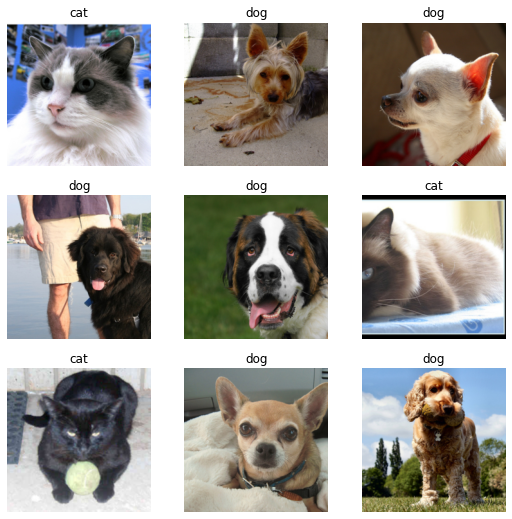

In [8]:
dls.show_batch()

## Creating the Model

In [9]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.9))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [10]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.174733,0.021714,0.987370,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.058512,0.026635,0.987370,00:24
1,0.030257,0.013254,0.994136,00:24


## Making Predictions

Here we try to make preditions where it can only predict cats and dogs. For others, it simply predict nothing.

In the learner, we used the accuracy with a probability thershold of 0.9. Which means, the probability should be higher than 0.9 to be consider it as a cat or dog.

Even with that, we got an accuracy of 99%. So, when predicting we can also use that as the threshold.

In [0]:
from ipywidgets import widgets

In [0]:
uploader = widgets.FileUpload()

In [0]:
# If couldn't find a way to create a prediction with a custom threshold.
# So, just created a one.
def predict(img, thresh):
  _, _, preds = learn.predict(img)
  res = preds > thresh
  return learn.dls.vocab[res], preds

In [0]:
def predictUploaded(thresh):
  uploaded_img = PILImage.create(uploader.data[-1])
  show_image(uploaded_img)
  return predict(uploaded_img, thresh)

In [15]:
uploader

FileUpload(value={}, description='Upload')

((#1) ['cat'], tensor([9.9999e-01, 1.3930e-06]))

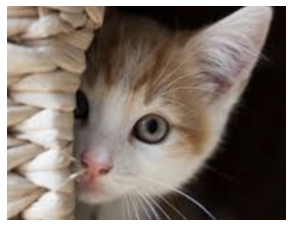

In [17]:
predictUploaded(0.9)

((#1) ['dog'], tensor([3.1949e-04, 9.9942e-01]))

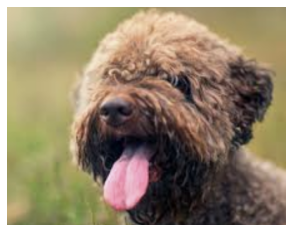

In [18]:
predictUploaded(0.9)

((#0) [], tensor([0.7762, 0.2974]))

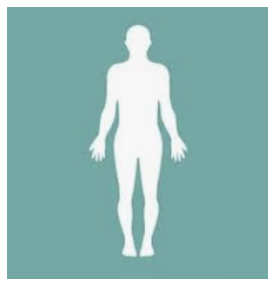

In [19]:
predictUploaded(0.9)

((#0) [], tensor([0.5872, 0.6303]))

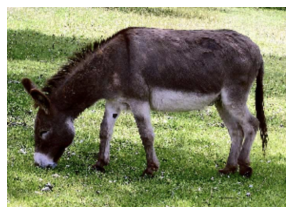

In [20]:
predictUploaded(0.9)

## Predicting with a large set of invalid images

Let's load some other dataset and get predictions.

In [195]:
preds = learn.get_preds(dl=dls.valid)[0]

In [0]:
has_predictions = (preds > 0.9).float().sum(dim=1) != 0

In [205]:
len(preds), has_predictions.sum()

(2217, tensor(2199))

In [84]:
other_dataset = untar_data(URLs.PASCAL_2007)
other_dataset.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.csv')]

In [0]:
other_db = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_items = get_image_files,
    get_y = lambda y: ['cat', 'dog'],
    item_tfms = Resize(224),
    splitter = RandomSplitter(0.3)
)

In [0]:
other_dls = other_db.dataloaders(other_dataset/"test")

In [208]:
len(other_dls.valid.items)

1485

In [223]:
preds_info = learn.get_preds(dl=other_dls.valid, with_input=True)
images = preds_info[0]
preds = preds_info[1]

In [0]:
has_predictions = (preds > 0.9).float().sum(dim=1) == 0

In [236]:
len(other_dls.valid.items), has_predictions.sum()

(1485, tensor(876))

In [0]:
img_preds_available = images[has_predictions]

In [238]:
len(img_preds_available)

876

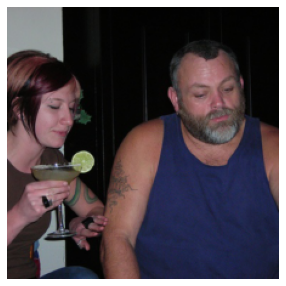

In [239]:
show_image(img_preds_available[0])

((#0) [], tensor([0.4981, 0.3188]))

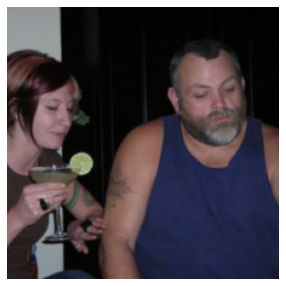

In [240]:
predictUploaded(0.9)

In [242]:
preds[0].sigmoid()

tensor([0.5099, 0.7293])